TODO:
 * precompute $\log|\Sigma_i|$
 * precomute swapped indices for parameter updates

In [1]:
using Distributions
using Seaborn

In [2]:
include("src/CHMM.jl")
# include("src/auxiliary.jl")
# include("src/chmm.jl")
# include("src/chmm_training.jl")

update_parameter_estimates! (generic function with 2 methods)

In [3]:
K = 5
KK = K^2
D = 3
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs_full) = rand_trajs(model, 
    T_range=100:300, N_pairs=100)
;

In [31]:
num_trajs = length(traj_ptr) - 1
num_pairs = length(traj_pairs_full)
traj_lens = diff(traj_ptr)

# drop a couple of trajectories
traj_pairs = traj_pairs_full[ randperm(num_pairs)[1:Int(num_pairs/2)] ]
# traj_pairs = traj_pairs_full[[1]] ##############################################################################
num_pairs = length(traj_pairs)

num_singles = num_trajs - num_pairs * 2
traj_singles = setdiff(1:num_trajs, vcat([[p...] for p in traj_pairs]...))
;

## EM

In [38]:
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)

log_p0 = log.(outer(curr.π0))

log_P = empty(KK, KK)
for k in 1:KK
    i, j = ind2sub((K, K), k)
    outer!(reshape(view(log_P, :, k), K, K), curr.P[:, i, j])
end
map!(log, log_P, log_P)

T_max = maximum(diff(traj_ptr))

log_b = empty(KK, T_max)
log_α = similar(log_b)
log_β = similar(log_b)
γ = similar(log_b)
;

In [39]:
N_iters = 50
log_like_hist = fill(NaN, N_iters)
verbose = true
conv_tol = 1e-3
print_every = 10

for iter in 1:N_iters
# for iter in 1
    log_like = 0.0
    zero!(suff)
    
    #
    # Pairwise Trajectories
    #
    for (id1, id2) in traj_pairs
        X1 = get_trajectory(id1, X, traj_ptr)
        X2 = get_trajectory(id2, X, traj_ptr)
        
        T = size(X1, 2)
        @assert T == size(X2, 2)
    
        data_likelihood!(PairwiseTrajectory, 
            curr, X1, X2, log_p0, log_P, log_b)
        log_like += forward_backward!(curr, T,
            log_p0, log_P, log_b, log_α, log_β, γ)
        update_suff_stats!(PairwiseTrajectory, 
            suff, X1, X2, log_p0, log_P, γ)
    end

    #
    # Single Trajectories
    #
    for id in traj_singles
        Xt = get_trajectory(id, X, traj_ptr)
        T = size(Xt, 2)
        
        data_likelihood!(SingleTrajectory, 
            curr, Xt, log_p0, log_P, log_b)
        log_like += forward_backward!(curr, T,
            log_p0, log_P, log_b, log_α, log_β, γ)
        update_suff_stats!(SingleTrajectory, 
            suff, Xt, log_p0, log_P, γ)
    end

    #
    # combine info from all trajectories
    #    
    update_parameter_estimates!(curr, suff)
    
    log_like_hist[iter] = log_like
    verbose && (iter % print_every == 0) && @printf("iteration %6d:  %.3f\n", iter, log_like)
    
    if (iter ≥ 2) && (abs(log_like_hist[iter] - log_like_hist[iter - 1]) ≤ conv_tol)
        break
    end
end

iteration     10:  -129528.539
iteration     20:  -129523.486
iteration     30:  -129523.428


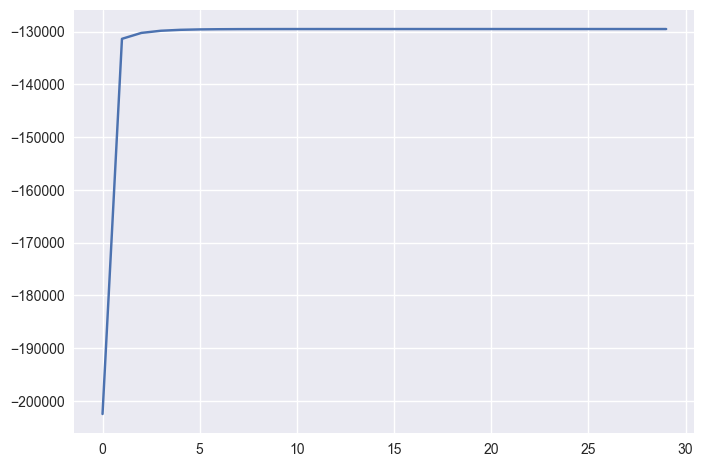

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001528048>

In [40]:
plot(log_like_hist)

# Analysis

In [43]:
true_to_est_lut = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est_lut[i] = indmin(r)
end

In [51]:
P_true = copy(model.P)
P_hat = copy( curr.P[true_to_est_lut, true_to_est_lut, true_to_est_lut] )
vecnorm(P_true .- P_hat)

0.7542858027583378

In [52]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_lut] )
vecnorm(p0_true .- p0_hat)

0.260674987069303

In [53]:
hcat([model.μs[i] .- curr.μs[true_to_est_lut[i]] for i in 1:K] ...)

3×5 Array{Float64,2}:
 -0.00051745  -0.00585367  0.0127641   0.00533968   0.000901718
  0.00116878   0.0125749   0.00284204  0.00282913   0.00791609 
  0.00034659   0.00791029  0.0123829   0.00236185  -0.0124476  

In [55]:
vcat([vecnorm(model.Σs[i] .- curr.Σs[true_to_est_lut[i]]) for i in 1:K] ...)

5-element Array{Float64,1}:
 0.000492593
 0.0211899  
 0.0528093  
 0.00178972 
 0.0117793  